# CCM Final Project
#### Baysian Modeling of Orientation WM prior

### Content
1. Load and Sort data
2. Prior Model Simulate
3. Fit Prior Model
4. Validation of Prior Model (Recover the params from the simulated data)

### 1. Load and Sort Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Kay: added some additional packages
from scipy.optimize import minimize
from scipy.special import logsumexp

In [2]:
curr_dif = os.getcwd()
data_dir = os.path.abspath(os.path.join(curr_dif, '..\\..\\'))
os.listdir(data_dir)

['.Rhistory',
 '.Rproj.user',
 'CCM_finalProject',
 'CCM_Final_23Spring.Rproj',
 'data',
 'data_beh.csv',
 'figures',
 'scripts']

In [3]:
data_path = os.path.join(data_dir,'data_beh.csv')
data = pd.read_csv(data_path,sep=',')

print(data.head())

   subjID  run  trial  phase  oriRef  oriJitt  oriFinal  oriRespInit  \
0       1    1      1      9       2       -9        36           63   
1       1    1      2      3       1       -9       171           85   
2       1    1      3      4       2       -1        44           58   
3       1    1      4      1       3        6        96           12   
4       1    1      5      3       4        3       138           43   

   oriRespFinal  error  points        rt  outoftime  iti  
0            62    -26      48  2.609021        NaN  0.2  
1           165      6      88  3.047162        NaN  0.2  
2            53     -9      82  2.500657        NaN  0.2  
3            99     -3      94  3.697208        NaN  0.2  
4           143     -5      90  3.665645        NaN  0.2  


In [4]:
data_df = pd.DataFrame(data)
flag = data_df['outoftime']!=1
print(sum(flag))
data_clean = data_df[flag]
# Kay: some additional cleaning and recoding
data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
data_clean['oriRespFinal2'] = data_clean['oriFinal2'] - data_clean['error']
data_clean['oriFinal3'] = data_clean['oriJitt']
data_clean['oriRespFinal3'] = data_clean['oriRespFinal2'] - data_clean['oriRef2']
data_clean = data_clean[data_clean['error'].abs() < 22.55]
data_clean

2319


C:\Users\kay\AppData\Local\Temp\ipykernel_13152\447142464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriRef2'] = (data_clean['oriRef']-1) * 45
C:\Users\kay\AppData\Local\Temp\ipykernel_13152\447142464.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['oriFinal2'] = data_clean['oriRef2'] + data_clean['oriJitt']
C:\Users\kay\AppData\Local\Temp\ipykernel_13152\447142464.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,subjID,run,trial,phase,oriRef,oriJitt,oriFinal,oriRespInit,oriRespFinal,error,points,rt,outoftime,iti,oriRef2,oriFinal2,oriRespFinal2,oriFinal3,oriRespFinal3
1,1,1,2,3,1,-9,171,85,165,6,88,3.047162,NaN,0.2,0,-9,-15,-9,-15
2,1,1,3,4,2,-1,44,58,53,-9,82,2.500657,NaN,0.2,45,44,53,-1,8
3,1,1,4,1,3,6,96,12,99,-3,94,3.697208,NaN,0.2,90,96,99,6,9
4,1,1,5,3,4,3,138,43,143,-5,90,3.665645,NaN,0.2,135,138,143,3,8
5,1,1,6,7,1,-9,171,152,164,7,86,1.547777,NaN,0.2,0,-9,-16,-9,-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,15,1,155,7,3,-1,89,93,88,1,98,2.375790,NaN,0.2,90,89,88,-1,-2
2395,15,1,156,1,3,0,90,18,91,-1,98,2.757365,NaN,0.2,90,90,91,0,1
2397,15,1,158,5,4,1,136,149,127,9,82,2.387765,NaN,0.2,135,136,127,1,-8
2398,15,1,159,2,2,-6,39,20,46,-7,86,1.181797,NaN,0.2,45,39,46,-6,1


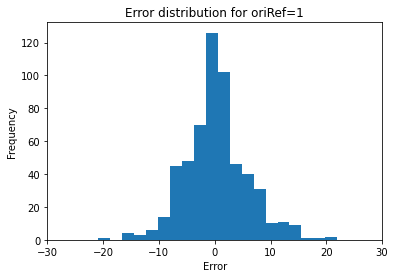

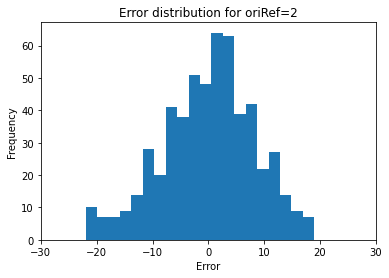

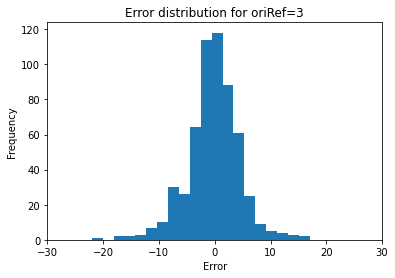

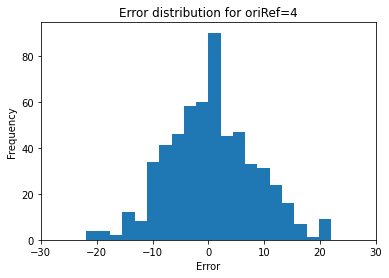

In [5]:
# Kay: an visualization
oriRefs = np.unique(data_clean['oriRef'])

for oriRef in oriRefs:
    data_oriRef = data_clean[data_clean['oriRef'] == oriRef]
    plt.hist(data_oriRef['error'], bins=20)
    plt.xlim(-30, 30)
    plt.title(f'Error distribution for oriRef={oriRef}')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.show()

In [6]:
data_ref1 = data_clean[data_clean['oriRef']==1 ]
data_ref2 = data_clean[data_clean['oriRef']==2 ]
data_ref3 = data_clean[data_clean['oriRef']==3 ]
data_ref4 = data_clean[data_clean['oriRef']==4 ]

#flip_flag = data_ref1['oriFinal'>=170]
#data_ref1['oriFinal'] = data_ref1[flip_flag,['oriFinal']]-180

In [7]:
data_ref2

,subjID,run,trial,phase,oriRef,oriJitt,oriFinal,oriRespInit,oriRespFinal,error,points,rt,outoftime,iti,oriRef2,oriFinal2,oriRespFinal2,oriFinal3,oriRespFinal3
2,1,1,3,4,2,-1,44,58,53,-9,82,2.500657,NaN,0.2,45,44,53,-1,8
8,1,1,9,1,2,8,53,112,57,-4,92,3.648202,NaN,0.2,45,53,57,8,12
10,1,1,11,9,2,7,52,80,69,-17,66,1.732261,NaN,0.2,45,52,69,7,24
11,1,1,12,2,2,-6,39,112,36,3,94,3.745060,NaN,0.2,45,39,36,-6,-9
12,1,1,13,10,2,9,54,76,65,-11,78,2.129156,NaN,0.2,45,54,65,9,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2374,15,1,135,8,2,8,53,18,57,-4,92,1.345367,NaN,0.2,45,53,57,8,12
2379,15,1,140,4,2,1,46,176,48,-2,96,1.399973,NaN,0.2,45,46,48,1,3
2380,15,1,141,2,2,3,48,87,48,0,100,1.466586,NaN,0.2,45,48,48,3,3
2385,15,1,146,6,2,-6,39,147,29,10,80,1.799879,NaN,0.2,45,39,29,-6,-16


### Prior Model Simulate

In [348]:
data_subj=data_ref2[data_ref2['subjID']==1]

targ_loc = np.array(subject_data['oriFinal'])
real_response = np.array(subject_data['oriRespFinal'])

In [355]:
def prior_simulate_data(targ_loc,prior_mu,prior_std,likelihood_std):
    posterior = [];
    answers = [];
    xs = np.linspace(-90, 90, 361)
    for i in range(targ_loc.shape[0]):
        representation = norm.pdf(xs, loc=targ_loc[i], scale=likelihood_std)
        prior = norm.pdf(xs, loc=prior_mu, scale=prior_std)
        post = representation * prior
        post = post/sum(post) # normalize
        
        random_answer = np.random.choice(xs,p = post)
        answers.append(random_answer)
        posterior.append(post[round(random_answer)])
        #errors = answers-targ_loc
    return answers,posterior

In [356]:
# let's try to simulate a fake subj when refence is 2

prior_mu = 45
prior_std = 25

likelihood_std = 15

answers,posterior = prior_simulate_data(targ_loc,prior_mu,prior_std,likelihood_std)
print(answers)

[43.0, 43.5, 52.0, 60.0, 36.5, 54.5, 61.5, 50.5, 65.5, 30.5, 53.5, 15.0, 72.0, 46.0, 58.0, 82.5, 79.0, 51.5, 38.5, 39.0, 53.0, 52.5, 49.0, 73.5, 46.5, 41.0, 47.0, 48.5, 59.5, 55.0, 35.0, 37.5, 23.0, 50.5, 57.0, 40.0, 50.0, 16.0, 37.5]


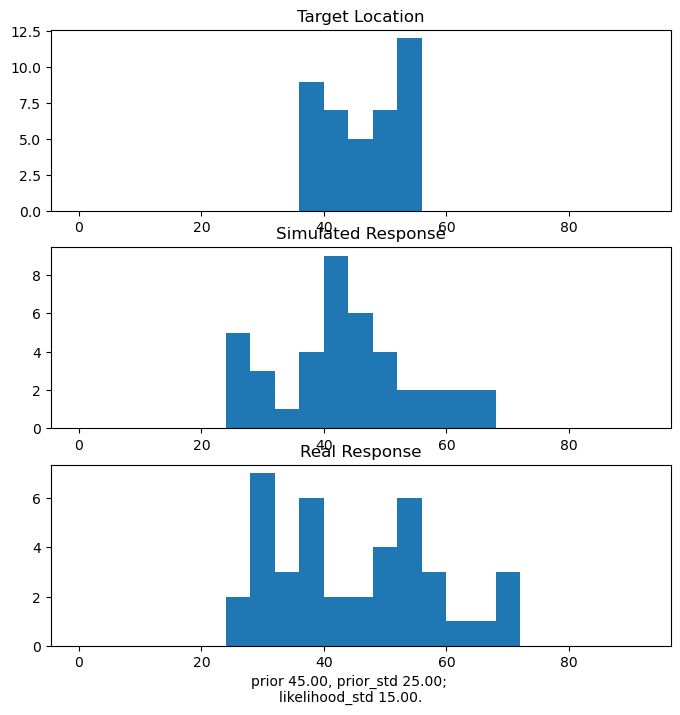

In [352]:
# Plot the target location histogram

# Define the bin sizes
bin_targ = 4

# Create the figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Plot the target location histogram
axs[0].hist(targ_loc, bins=np.arange(0, 90 + bin_targ, bin_targ))
axs[0].set_title('Target Location')

# Plot the response location histogram
axs[1].hist(answers, bins=np.arange(0, 90 + bin_targ, bin_targ))
axs[1].set_title('Simulated Response')

# Plot the response error histogram
axs[2].hist(real_response, bins=np.arange(0, 90 + bin_targ, bin_targ))
axs[2].set_title('Real Response')
# Set the x-label with the parameters
xtxt = f"prior {prior_mu:.2f}, prior_std {prior_std:.2f}; \nlikelihood_std {likelihood_std:.2f}."
fig.text(0.5, 0.04, xtxt, ha='center')

# Show the plot
plt.show()

### 3.Fit Prior Model

In [10]:
# Kay: data of subject 2 at 45 degree
data_ref2 = data_clean[data_clean['oriRef2'] == 45 ]
subject_data = data_ref2[data_ref2['subjID']==1]
targ_loc = np.array(subject_data['oriFinal3'])
real_response = np.array(subject_data['oriRespFinal3'])
subject_data
targ_loc = np.array(subject_data['oriFinal3'])
true_answer = np.array(subject_data['oriRespFinal3'])

In [13]:
def prior_nll(targ_loc,true_answer, prior_std, likelihood_std):
# Kay: changed name a bit, no big deal
# def prior_cal_nll(targ_loc,true_answer, params):
    ntrials = targ_loc.shape[0]
    
    xs = np.linspace(-90, 90, 181)
    # Kay: all centered at 0 and the spread is 180 degree
    # xs = np.arange(-45, 135, 0.01)
    prior_mu = 0
    # Kay: all centered so prior is always 0
    # prior_mu = params[0]
    # Kay: take args as input
    # prior_std = params[1]
    #likelihood_std = params[2]
    
    # can create prior outside of the loop because doesn't change
    log_prior = norm.logpdf(xs, loc=prior_mu, scale=prior_std)
    log_prior = np.tile(log_prior, (ntrials, 1))
    # Kay: used logpdf rather than pdf
    # Kay: created the log_prior as a 40*181 array, 
    # Kay: each sub-array is a distribution, which I think your array is a 181*40
    #prior = norm.pdf(xs, loc=prior_mu, scale=prior_std)
    #prior = np.tile(prior[:, np.newaxis], (1, int(ntrials)))

    # representation is also easy to do without a loop
    log_likelihood = norm.logpdf(xs.reshape(1, -1), loc=targ_loc[:, np.newaxis], scale=likelihood_std)
    #  Kay: same, I created 40*181 array rather than 181*40 array, idea is the same
    #representation = norm.pdf(xs.reshape(-1,1), loc=targ_loc, scale=likelihood_std)

    log_post_unnormalized = log_likelihood + log_prior
    # Kay: since its log scale, we will just add
    #post = representation * prior
    normalizing_factor = logsumexp(log_post_unnormalized)
    log_post = log_post_unnormalized - normalizing_factor
    # Kay: normalizaed the posterior
    nll = -log_post
    
    #post = post/np.sum(post, axis=1, keepdims=True)
    # Kay: also the original code may have a small mistake here
    # Kay: the `np.sum(post, axis=1, keepdims=True)` 
    # Kay: should use axis = 0 if you are using a 181*40 array

    # this is the true answer
    #xs_matrix = np.tile(xs, (ntrials,1))
    
    #true_answer = true_answer.values
    
    
    # Kay: I'm not sure about the very idea of the below codes, 
    # Kay: but I think it's trying to find the posterior probability of the true answer for each trail and add up them together?
    # Kay: if so, the below code would work the same
    # Kay: and as our degrees are all integers, there is no need for rounding
    nLL = []
    for i in range(0,len(true_answer)):
        trial_true = (true_answer[i] + 90).astype(int)
        trail_nll = nll[i]
        trail_nLL = trail_nll[trial_true]
        nLL.append(trail_nLL)
    return np.sum(np.array(nLL))
    
    #index = np.argmin(np.abs(xs_matrix - true_answer.reshape(-1,1)), axis=1) #find the closest one
    
    #if len(index) != len(true_answer):
        #raise ValueError('the num of llh is not the number of trial')

    #col_post = post.flatten(order='F')
    #col_probs = col_post[index]
    #llh = np.sum(np.log(col_probs))
    #nLL = -llh 

    #return nLL


In [17]:
# Kay: let's try to fit it to the one subject data we got
prior_nll(targ_loc,true_answer, 10, 10)

301.6678700029742

In [372]:
nparams = 3
nsubjs = 15

prior_std_range = np.arange(1, 30, 2)
likelihood_std_range = np.arange(.1,10,.5);


allfits = np.empty((niters, nparams))
nLL_total = np.empty((len(prior_std_range),len(likelihood_std_range)))
prior_std_fit = np.empty((nsubjs))
likelihood_std_fit = np.empty((nsubjs))
the_nLL = np.empty((nsubjs))

for subj in range(nsubjs):
    subject_data =  pd.DataFrame(data_ref2[data_ref2['subjID']==subj+1])
        
    targ_loc = np.array(subject_data['oriFinal'])
    true_answer = np.array(subject_data['oriRespFinal'])
    print(subj)
    for prior_idx in range(len(prior_std_range)):
        for likelihood_idx in range(len(likelihood_std_range)):
            # remember to change the 45 into other prior mu based on the data set u r using
            nll=prior_cal_nll(targ_loc,true_answer,[45, prior_std_range[prior_idx],likelihood_std_range[likelihood_idx]])
            
            nLL_total[prior_idx,likelihood_idx] = nll
    
    the_nLL = np.min(nLL_total) # final fitted nll
    I = np.nanargmin(nLL_total)

    j_idx = np.ceil(I / len(prior_std_range)).astype(int)-1
    i_idx = I - (j_idx) * len(prior_std_range) - 1

    prior_std_fit[subj] = prior_std_range[i_idx] # final fitted prior std
    likelihood_std_fit[subj] = likelihood_std_range[j_idx] # final fitted likelihood std

0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19148\3691053948.py:18: RuntimeWarning: invalid value encountered in divide
  post = post/np.sum(post, axis=1, keepdims=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19148\3691053948.py:32: RuntimeWarning: divide by zero encountered in log
  llh = np.sum(np.log(col_probs))


1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [373]:
prior_std_fit

array([ 7.,  7.,  7.,  7.,  7.,  7., 17., 17.,  7.,  7.,  7.,  7., 17.,
       17.,  7.])

In [374]:
likelihood_std_fit

array([0.6, 0.6, 0.6, 4.6, 0.6, 0.6, 1.1, 1.1, 0.6, 0.6, 0.6, 2.6, 1.1,
       1.1, 0.6])

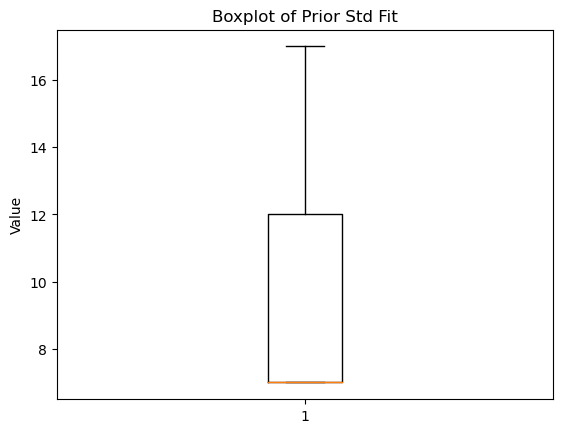

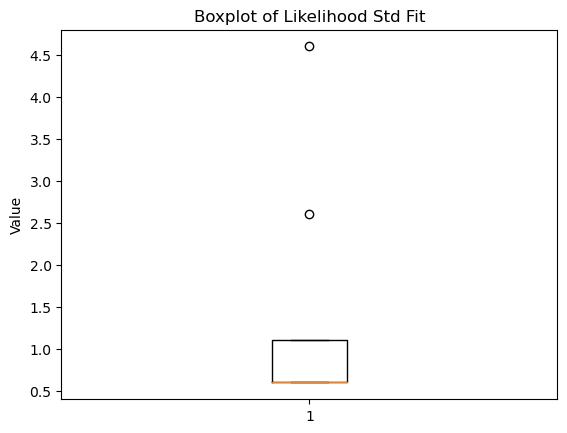

In [375]:
import matplotlib.pyplot as plt

# create boxplot for prior_std_fit
fig1, ax1 = plt.subplots()
ax1.boxplot(prior_std_fit)
ax1.set_title('Boxplot of Prior Std Fit')
ax1.set_ylabel('Value')

# create boxplot for likelihood_std_fit
fig2, ax2 = plt.subplots()
ax2.boxplot(likelihood_std_fit)
ax2.set_title('Boxplot of Likelihood Std Fit')
ax2.set_ylabel('Value')

plt.show()


#### It's not working now (fmin)
#### I tried to use fmin but the targ_loc i pass in was 40 by 1 after pass in it became 3 by 1 werid.

In [18]:
# Kay: try to optimize
def wrapped_prior_nll(params, targ_loc, true_answer):
    prior_std, likelihood_std = params
    return prior_nll(targ_loc,true_answer, prior_std, likelihood_std)

# Set initial guesses for prior_std and likelihood_std
init_guess_prior = [10, 10]  # [prior_std_guess, likelihood_std_guess]

result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc, true_answer), bounds=((1e-5, 100), (1e-5, 100)))
recovered_prior_std, recovered_likelihood_std = result_prior_synthetic.x

print("Optimized prior_std:", recovered_prior_std)
print("Optimized likelihood_std (with prior):", recovered_likelihood_std)

Optimized prior_std: 100.0
Optimized likelihood_std (with prior): 9.515945859740919


**Kay: It's observed that the optimization seem to estimate the standard deviation of the prior very large. This could either be due to that people do not have prior, or it could be an optimization problem. To solve this, we can use some generated data.**

In [ ]:
from scipy.optimize import fmin

options = {'ftol': 1e-8, 'disp': False}
nparams = 3
pmin = np.ones(nparams) * 1
pmax = np.ones(nparams) * 50
nsubjs = 15
niters = 1
allfits = np.empty((niters, nparams))
nll = np.empty((niters, 1))
best_params = np.empty((nsubjs, nparams))
min_nll = np.empty((nsubjs, 1))

for subj in range(nsubjs):
    subject_data =  pd.DataFrame(data_ref2[data_ref2['subjID']==subj+1])
    targ_loc = np.array(subject_data['oriFinal'])
    true_answer = np.array(subject_data['oriRespFinal'])
    
    print(targ_loc)
    
    init = np.random.uniform(pmin, pmax, nparams)
    # randomly initialize the starting point
    
    #nll=prior_cal_nll(subject_data, init)    
    #print(nll)
    allfits[iter, :], nll[iter] = fmin(prior_cal_nll, init, args=([targ_loc],[true_answer],), maxiter=500, full_output=True, disp=False)
    # returns the best fit parameters and their values
    
    # do all of that niters times, then pick the best ones
    idx = np.argmin(nll)
    min_nll[subj, :] = nll[idx]
    best_params[subj, :] = allfits[idx, :]
    #print(min_nll[subj,:])
    #print(best_params[subj,:])

### 4. Validation of Prior Model (Recover the params from the simulated data)

In [19]:
# Kay: define a function that generates data
def generate_synthetic_data_prior(n_samples, prior_mu, prior_std, likelihood_std):
    real_response = []
    # Generate target locations (targ_loc) from the prior
    targ_loc = np.random.normal(prior_mu, prior_std, n_samples)
    targ_loc = np.round(targ_loc)
    targ_loc = np.clip(targ_loc, -90, 90)
    # Generate real_response values by adding noise to the targ_loc values
    for i in targ_loc:
        real_response.append(np.clip(i + np.round(np.random.normal(0, likelihood_std)), -90, 90))
    return targ_loc, np.array(real_response)

n_samples = 1000
prior_mu = 0

prior_std = 10
likelihood_std = 10

targ_loc, true_answer = generate_synthetic_data_prior(n_samples, prior_mu, prior_std, likelihood_std)

# Kay: Try to recover the parameters
result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc, true_answer), bounds=((1e-5, 100), (1e-5, 100)))
recovered_prior_std, recovered_likelihood_std = result_prior_synthetic.x

print("True prior_std:", prior_std)
print("Recovered prior_std:", recovered_prior_std)
print("True likelihood_std:", likelihood_std)
print("Recovered likelihood_std (with prior):", recovered_likelihood_std)

True prior_std: 10
Recovered prior_std: 100.0
True likelihood_std: 10
Recovered likelihood_std (with prior): 10.14135640986117


**Seem like the problem is from the model or optimization, let's check if the optimizer actually stucked at local minimum, that is the nll at true prior_std should be smaller than recovered prior_std**

In [22]:
# Kay: if it's an optimization failier, the nll at true prior_std should be smaller than recovered prior_std
print("Nll at true parameters", prior_nll(targ_loc,true_answer, 10, 10))
print("Nll at estimated parameters", prior_nll(targ_loc,true_answer, 100, 10.14135640986117))

Nll at true parameters 11150.438103237218
Nll at estimated parameters 10638.662101062457


**Seem like the problem is not from optimization. Could also try to vary the start point, parameters and increase sample.**

In [23]:
# Kay
n_samples = 1000
prior_mu = 0

prior_std = []
likelihood_std = []

recovered_prior_std = []
recovered_likelihood_std = []
recovered_nll = []
initial_nll = []

for i in range(0, 1000):
    i_prior_std = np.random.randint(1, 20, 1)
    prior_std.append(i_prior_std)
    i_likelihood_std = np.random.randint(1, 20, 1)
    likelihood_std.append(i_likelihood_std)
    targ_loc, true_answer = generate_synthetic_data_prior(n_samples, prior_mu, i_prior_std, i_likelihood_std)
    init_guess_prior = [np.random.normal(20, 15), np.random.normal(20, 15)]
    result_prior_synthetic = minimize(wrapped_prior_nll, init_guess_prior, 
                                  args=(targ_loc, true_answer), bounds=((1e-5, 500), (1e-5, 500)))
    i_recovered_prior_std, i_recovered_likelihood_std = result_prior_synthetic.x
    recovered_prior_std.append(i_recovered_prior_std)
    recovered_likelihood_std.append(i_recovered_likelihood_std)
    recovered_nll.append(prior_nll(targ_loc,true_answer, i_recovered_prior_std, i_recovered_likelihood_std))
    initial_nll.append(prior_nll(targ_loc,true_answer, 10, 10))
    
output_dict = {
    'prior_std':prior_std,
    'recovered_prior_std': recovered_prior_std,
    'likelihood_std':likelihood_std,
    'recovered_likelihood_std': recovered_likelihood_std,
    'recovered_nll': recovered_nll,
    'initial_nll': initial_nll
}

simulation_df = pd.DataFrame(output_dict)
pd.set_option('display.max_rows', None)
simulation_df

,prior_std,recovered_prior_std,likelihood_std,recovered_likelihood_std,recovered_nll,initial_nll
0,[13],202.136301,[8],8.119513,10420.317724,10964.825283
1,[9],55.766221,[10],10.081940,10621.186565,10966.739496
2,[3],56.424709,[4],4.037928,9719.852242,9965.278847
3,[6],18.426991,[16],499.737367,11239.680862,12917.670021
4,[2],16.230800,[16],498.863556,11113.059589,12385.746234
5,[4],40.798803,[2],2.007330,9022.389099,9865.336549
6,[12],235.596560,[12],12.086831,10817.550098,11718.330233
7,[18],95.996776,[19],20.398583,11316.980602,14725.628507
8,[7],47.697637,[15],15.571080,11021.401758,12059.989086
9,[4],38.205365,[7],7.014963,10258.145000,10293.293167


In [24]:
# Kay: correlation
output_dict = {
    'prior_std':[x[0] for x in prior_std],
    'recovered_prior_std': recovered_prior_std,
    'likelihood_std':[x[0] for x in likelihood_std],
    'recovered_likelihood_std': recovered_likelihood_std,
    'recovered_nll': recovered_nll,
    'initial_nll': initial_nll
}

simulation_df = pd.DataFrame(output_dict)
#pd.set_option('display.max_rows', None)
# simulation_df
#[simulation_df['recovered_nll'] >= simulation_df['initial_nll']]

corr = simulation_df['prior_std'].corr(simulation_df['recovered_prior_std'])
print(f"The correlation between prior_std and recovered_prior_std is: {corr:.3f}")

The correlation between prior_std and recovered_prior_std is: 0.347
The correlation between likelihood_std and recovered_likelihood_std is: 0.256


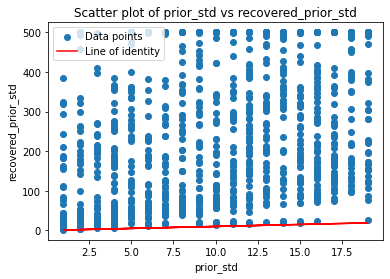

In [25]:
# Kay: visualization
x = simulation_df['prior_std']
y = simulation_df['recovered_prior_std']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('prior_std')
plt.ylabel('recovered_prior_std')
plt.title('Scatter plot of prior_std vs recovered_prior_std')
plt.legend()
plt.show()

The correlation between likelihood_std and recovered_likelihood_std is: 0.995


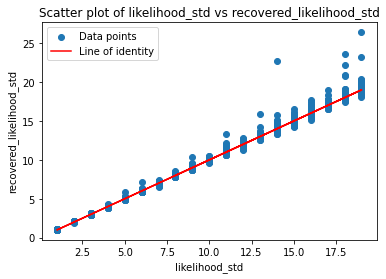

In [30]:
# Kay: visualization
simulation_df2 = simulation_df[simulation_df['recovered_likelihood_std'] < 30]
corr2 = simulation_df2['likelihood_std'].corr(simulation_df2['recovered_likelihood_std'])
print(f"The correlation between likelihood_std and recovered_likelihood_std is: {corr2:.3f}")

x = simulation_df2['likelihood_std']
y = simulation_df2['recovered_likelihood_std']

plt.scatter(x, y, label='Data points')
plt.plot(x, x, color='r', label='Line of identity')
plt.xlabel('likelihood_std')
plt.ylabel('recovered_likelihood_std')
plt.title('Scatter plot of likelihood_std vs recovered_likelihood_std')
plt.legend()
plt.show()

**Kay: It seems that the optimization is able to recover the likelihood_std most of the time but cannot recover the prior_std**

In [384]:
prior_std_range = np.arange(1, 30, 2)
likelihood_std_range = np.arange(.1,10,.5);

allfits = np.empty((niters, nparams))
nLL_retotal = np.empty((len(prior_std_range),len(likelihood_std_range)))
prior_std_refit = np.empty((nsubjs))
likelihood_std_refit = np.empty((nsubjs))
the_renLL = np.empty((nsubjs))

for subj in range(nsubjs):
    subject_data =  pd.DataFrame(data_ref2[data_ref2['subjID']==subj+1])
        
    targ_loc = np.array(subject_data['oriFinal'])
    true_answer = np.array(subject_data['oriRespFinal'])
    print(subj)
    
    prior_mu = 45
    prior_std = prior_std_fit[subj]

    likelihood_std = likelihood_std_fit[subj]

    simu_answers,posterior = prior_simulate_data(targ_loc,prior_mu,prior_std,likelihood_std)
    simu_answers = np.array(simu_answers)
    
    for prior_idx in range(len(prior_std_range)):
        for likelihood_idx in range(len(likelihood_std_range)):
            # remember to change the 45 into other prior mu based on the data set u r using
            nll=prior_cal_nll(targ_loc,simu_answers,[45, prior_std_range[prior_idx],likelihood_std_range[likelihood_idx]])
            
            nLL_retotal[prior_idx,likelihood_idx] = nll
    
    the_renLL[subj] = np.min(nLL_retotal) # final fitted nll
    I = np.nanargmin(nLL_retotal)

    j_idx = np.ceil(I / len(prior_std_range)).astype(int)-1
    i_idx = I - (j_idx) * len(prior_std_range) - 1

    prior_std_refit[subj] = prior_std_range[i_idx]  # refitted prior std
    likelihood_std_refit[subj] = likelihood_std_range[j_idx] # refitted likelihood std

0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_19148\3691053948.py:18: RuntimeWarning: invalid value encountered in divide
  post = post/np.sum(post, axis=1, keepdims=True)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_19148\3691053948.py:32: RuntimeWarning: divide by zero encountered in log
  llh = np.sum(np.log(col_probs))


1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [385]:
correlation_data = np.corrcoef(true_answer, simu_answers)[0,1]
correlation_likelihood = np.corrcoef(likelihood_std_refit, likelihood_std_fit)[0,1]
correlation_prior = np.corrcoef(prior_std_fit, prior_std_refit)[0,1]

print([correlation_data, correlation_likelihood, correlation_prior])


[0.6879474780552982, 0.08537792937171511, 0.004236147413513745]


In [386]:
likelihood_std_refit

array([0.6, 0.6, 0.6, 1.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.1, 0.6, 0.1, 0.1,
       8.6, 0.6])

In [387]:
likelihood_std_fit

array([0.6, 0.6, 0.6, 4.6, 0.6, 0.6, 1.1, 1.1, 0.6, 0.6, 0.6, 2.6, 1.1,
       1.1, 0.6])

In [388]:
prior_std_refit

array([ 7.,  3.,  7., 27.,  3.,  7.,  7.,  7.,  7., 29.,  7., 27., 27.,
        7.,  7.])

In [389]:
prior_std_fit

array([ 7.,  7.,  7.,  7.,  7.,  7., 17., 17.,  7.,  7.,  7.,  7., 17.,
       17.,  7.])

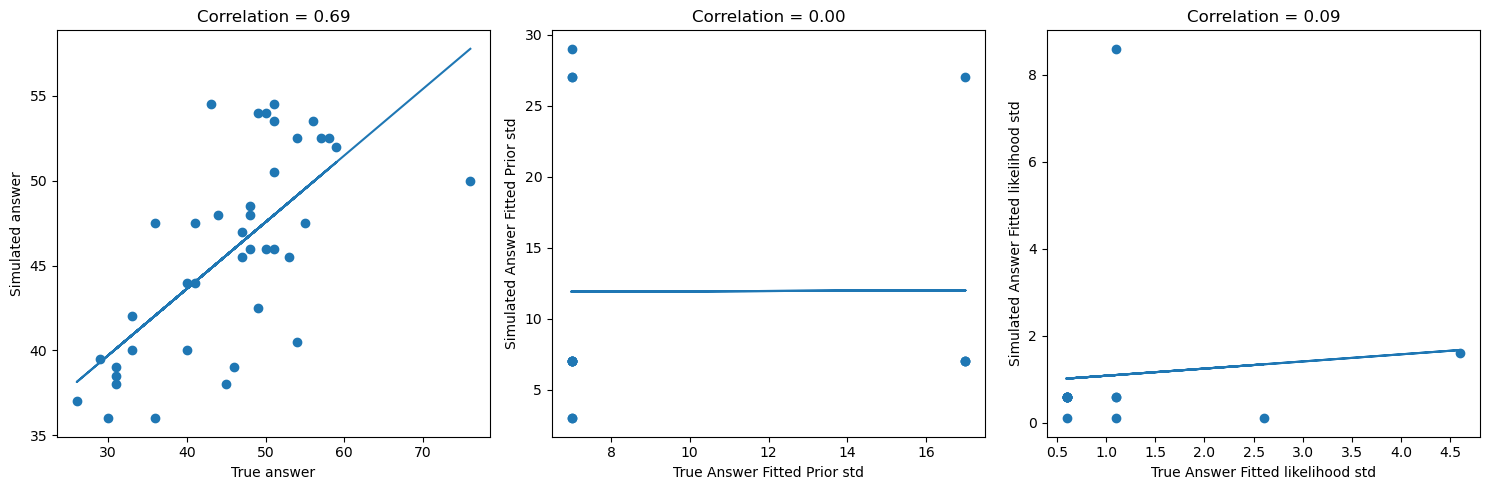

In [390]:
# Plot the real data, simulated data

# Draw scatter plots and lines
fig, axs = plt.subplots(1, 3, figsize=(15,5))

# True answer and prior fit
axs[0].scatter(true_answer, simu_answers)
m, b = np.polyfit(true_answer, simu_answers, 1)
axs[0].plot(true_answer, m*true_answer + b)
axs[0].set_xlabel('True answer')
axs[0].set_ylabel('Simulated answer')
axs[0].set_title('Correlation = {:.2f}'.format(correlation_data))


#Plot the real data fitted params, and simulated data fitted params

# True and simulated data fitted prior
axs[1].scatter(prior_std_fit, prior_std_refit)
m, b = np.polyfit(prior_std_fit, prior_std_refit, 1)
axs[1].plot(prior_std_fit, m*prior_std_fit + b)
axs[1].set_xlabel('True Answer Fitted Prior std')
axs[1].set_ylabel('Simulated Answer Fitted Prior std')
axs[1].set_title('Correlation = {:.2f}'.format(correlation_prior))

# True and simulated data fitted likelihood
axs[2].scatter(likelihood_std_fit, likelihood_std_refit)
m, b = np.polyfit(likelihood_std_fit, likelihood_std_refit, 1)
axs[2].plot(likelihood_std_fit, m*likelihood_std_fit + b)
axs[2].set_xlabel('True Answer Fitted likelihood std')
axs[2].set_ylabel('Simulated Answer Fitted likelihood std')
axs[2].set_title('Correlation = {:.2f}'.format(correlation_likelihood))

plt.tight_layout()
plt.show()

Model validation 不太好，我感觉可能是simulate有问题，simulate的时候算完posterior之后，我是按那个pdf的频率随机再抽一个数，（另一种选择是直接选posterior最大值对应的点，但那个的simulate结果error都特别小..）或者可能是fit的时候gride search每一步比较大，精确性不高，但现有的计算已经很耗时间了...